# Session 2.3: BakeryAI - Introduction to LangGraph

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mVK3kITwpKL2pfAZKwAknlexl2TegHAD?usp=sharing)

## 🎯 What is LangGraph?

**LangGraph** is a framework for building **stateful, multi-actor applications** with LLMs.

### Why LangGraph?

Traditional agents have limitations:
- ❌ Hard to control flow
- ❌ Limited state management
- ❌ Difficult to debug
- ❌ Can't handle complex workflows

**LangGraph solves this** by:
- ✅ Explicit state management
- ✅ Visual workflow graphs
- ✅ Conditional routing
- ✅ Human-in-the-loop
- ✅ Parallel execution
- ✅ Easy debugging

### Core Concepts:
1. **Nodes**: Units of work (functions that process state)
2. **Edges**: Connections between nodes
3. **State**: Shared data that flows through the graph
4. **Conditional Edges**: Dynamic routing based on state

## BakeryAI with LangGraph

We'll build a sophisticated order processing workflow using the tools from previous notebooks:

```
Customer Request
    ↓
[Understand Intent]
    ↓
[Lookup Customer] → Human Review if not found
    ↓
[Check Product Availability] → Recommend Alternatives if unavailable
    ↓
[Calculate Price]
    ↓
[Check Delivery Slot] → Suggest Alternative Times if unavailable
    ↓
[Process Payment] → Retry or Human Review if failed
    ↓
[Send Confirmation Email]
```

Let's build it! 🚀

In [3]:
!pip install -q langgraph langchain langchain-openai
!pip install -q pandas python-dotenv

!git clone https://github.com/IvanReznikov/mdx-langchain-conclave

fatal: destination path 'mdx-langchain-conclave' already exists and is not an empty directory.


In [ ]:
import os
from google.colab import userdata

# Set OpenAI API key from Google Colab's user environment or default
def set_openai_api_key(default_key: str = "YOUR_API_KEY") -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""
    #if not (userdata.get("OPENAI_API_KEY") or "OPENAI_API_KEY" in os.environ):
    try:
      os.environ["OPENAI_API_KEY"] = userdata.get("MDX_OPENAI_API_KEY")
    except:
      os.environ["OPENAI_API_KEY"] = default_key

set_openai_api_key()
#set_openai_api_key("sk-...")

In [5]:
import os
import pandas as pd
import random
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, List
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
# Load bakery data
try:
    cakes_df = pd.read_csv('/content/mdx-langchain-conclave/data/cake_descriptions.csv', encoding='cp1252')
    customers_df = pd.read_csv('/content/mdx-langchain-conclave/data/customers.csv', encoding='cp1252')
    orders_df = pd.read_csv('/content/mdx-langchain-conclave/data/orders.csv', encoding='cp1252')
    prices_df = pd.read_csv('/content/mdx-langchain-conclave/data/price_list.csv', encoding='utf-16')
    print(f"✅ Loaded: {len(cakes_df)} products, {len(customers_df)} customers, {len(orders_df)} orders")
except FileNotFoundError:
    cakes_df = pd.DataFrame({
        'Name': ['Chocolate Truffle Cake', 'Vanilla Bean Cake', 'Red Velvet Cake'],
        'Category': ['Chocolate', 'Vanilla', 'Specialty'],
        'Available': [True, True, True],
        'Weight_grams': [1000, 1000, 1200],
        'Delivery_time_hr': [24, 24, 48]
    })
    customers_df = pd.DataFrame({
        'client_id': ['C001'],
        'client_name': ['Alice Johnson'],
        'email': ['alice@example.com'],
        'loyalty_points': [100]
    })
    orders_df = pd.DataFrame({'order_id': ['O001'], 'status': ['delivered']})
    prices_df = pd.DataFrame({'Item': ['Chocolate Cake'], 'Unit_Price_AED': [45]})
    print("⚠️ Using sample data")

✅ Loaded: 22 products, 50 customers, 100 orders


## 1. Import Tools from Previous Notebooks

We'll reuse the tools we built in Notebooks 1 and 2.

In [7]:
# Tools from Notebook 1: Basic agent tools
@tool
def check_product_availability(product_name: str) -> str:
    """Check if a product is available in inventory.

    Args:
        product_name: Name of the cake or product to check

    Returns:
        Availability status and details
    """
    product = cakes_df[cakes_df['Name'].str.contains(product_name, case=False, na=False)]

    if product.empty:
        return f"Product '{product_name}' not found in our catalog."

    product_info = product.iloc[0]
    if product_info['Available']:
        return f"✅ {product_info['Name']} is available! Delivery time: {product_info['Delivery_time_hr']} hours."
    else:
        return f"❌ {product_info['Name']} is currently out of stock."

@tool
def calculate_order_total(product_name: str, quantity: int = 1) -> str:
    """Calculate the total cost including delivery fee.

    Args:
        product_name: Name of the product
        quantity: Number of items (default: 1)

    Returns:
        Total cost breakdown
    """
    try:
        filtered = prices_df[prices_df['Item'].str.lower().str.contains(product_name.lower(), na=False)]
        price = filtered['Unit_Price_AED'].iloc[0]
    except:
        price = 45  # default

    subtotal = price * quantity
    delivery_fee = 10 if subtotal < 100 else 0
    total = subtotal + delivery_fee

    return f"""Order Summary:
- Product: {product_name} x {quantity}
- Subtotal: {subtotal} AED
- Delivery Fee: {delivery_fee} AED
- Total: {total} AED"""

@tool
def check_delivery_slot(date: str, time: str) -> str:
    """Check if a delivery slot is available.

    Args:
        date: Delivery date (e.g., 'tomorrow', '2025-10-23')
        time: Delivery time (e.g., '2 PM', '14:00')

    Returns:
        Slot availability status
    """
    # Simulate availability check (90% success rate)
    is_available = random.random() < 0.9

    if is_available:
        return f"✅ Delivery slot available for {date} at {time}. We'll deliver between {time} and one hour after."
    else:
        return f"❌ Delivery slot for {date} at {time} is fully booked. Alternative times: 10 AM, 4 PM."

In [8]:
# Tools from Notebook 2: Advanced tools
@tool
def lookup_customer(query: str) -> str:
    """Look up customer information by name, email, or ID.

    Args:
        query: Customer identifier (name, email, or ID)

    Returns:
        Customer information as formatted string
    """
    query_lower = query.lower()

    # Try matching by ID
    if 'client_id' in customers_df.columns:
        customer = customers_df[customers_df['client_id'].str.lower() == query_lower]
    else:
        customer = pd.DataFrame()

    # Try matching by name if ID search failed
    if customer.empty and 'client_name' in customers_df.columns:
        customer = customers_df[customers_df['client_name'].str.lower().str.contains(query_lower, na=False)]

    if customer.empty:
        return f"❌ Customer '{query}' not found in database."

    cust = customer.iloc[0]
    result = f"""✅ Customer Found:
- ID: {cust.get('client_id', 'N/A')}
- Name: {cust.get('client_name', 'N/A')}
- Email: {cust.get('email', 'N/A')}
- Loyalty Points: {cust.get('loyalty_points', 0)}"""

    return result

@tool
def process_payment(customer_id: str, amount: float, payment_method: str = "card") -> str:
    """Process payment for an order.

    Args:
        customer_id: Customer ID
        amount: Payment amount
        payment_method: Payment method (card, cash, wallet)

    Returns:
        Payment confirmation
    """
    import time
    time.sleep(0.5)  # Simulate API delay

    # 95% success rate
    success = random.random() < 0.95

    if success:
        transaction_id = f"TXN{random.randint(100000, 999999)}"
        return f"""✅ Payment Successful!
Transaction ID: {transaction_id}
Customer: {customer_id}
Amount: ${amount:.2f}
Method: {payment_method}
Status: Approved"""
    else:
        return f"""❌ Payment Failed
Reason: Insufficient funds / Card declined
Please try a different payment method."""

@tool
def send_confirmation_email(customer_email: str, order_id: str, order_details: str) -> str:
    """Send order confirmation email to customer.

    Args:
        customer_email: Customer's email address
        order_id: Order ID
        order_details: Order details to include

    Returns:
        Email send status
    """
    import time
    time.sleep(0.3)

    return f"""📧 Email Sent Successfully!
To: {customer_email}
Subject: Order Confirmation - #{order_id}
Status: Delivered to inbox"""

# Collect all tools
bakery_tools = [
    check_product_availability,
    calculate_order_total,
    check_delivery_slot,
    lookup_customer,
    process_payment,
    send_confirmation_email
]

print("✅ All tools imported from previous notebooks")
print(f"Available tools: {[tool.name for tool in bakery_tools]}")

✅ All tools imported from previous notebooks
Available tools: ['check_product_availability', 'calculate_order_total', 'check_delivery_slot', 'lookup_customer', 'process_payment', 'send_confirmation_email']


## 2. Defining the State

State is the core of LangGraph - it flows through all nodes.

In [9]:
class BakeryOrderState(TypedDict):
    """State for the bakery order workflow"""
    # Customer info
    customer_query: str
    customer_id: str
    customer_name: str
    customer_email: str

    # Order details
    requested_product: str
    quantity: int
    delivery_date: str
    delivery_time: str

    # Workflow state
    intent: str  # 'order', 'inquiry', 'complaint'
    customer_found: bool
    product_available: bool
    delivery_available: bool
    price: float
    payment_status: str  # 'pending', 'paid', 'failed'
    order_id: str

    # Messages for conversation
    messages: Annotated[List[BaseMessage], add_messages]

    # Flags
    requires_human_review: bool
    workflow_complete: bool
    error_message: str

print("✅ State schema defined")

✅ State schema defined


## 3. Creating Agent-Powered Nodes

Instead of simple functions, we'll create nodes that use the LLM with tools.

In [10]:
# Bind tools to LLM
llm_with_tools = llm.bind_tools(bakery_tools)

In [11]:
def understand_intent_node(state: BakeryOrderState) -> BakeryOrderState:
    """Analyze customer intent using LLM"""
    print("🧠 NODE: Understanding Intent...")

    last_message = state['messages'][-1].content if state['messages'] else ""

    # Use LLM to understand intent
    intent_prompt = f"""Analyze this customer message and determine the intent.

Message: "{last_message}"

Classify as one of: 'order', 'inquiry', 'complaint', 'tracking'
Respond with just the intent word."""

    response = llm.invoke([HumanMessage(content=intent_prompt)])
    intent = response.content.lower().strip()

    # Default to order if unclear
    if intent not in ['order', 'inquiry', 'complaint', 'tracking']:
        intent = 'order'

    state['intent'] = intent
    print(f"   Intent detected: {intent}")

    return state

def lookup_customer_node(state: BakeryOrderState) -> BakeryOrderState:
    """Look up customer using the tool"""
    print("👤 NODE: Looking up customer...")

    # Extract customer identifier from messages
    customer_query = state.get('customer_query', state.get('customer_name', ''))

    if not customer_query:
        # Try to extract from last message
        last_message = state['messages'][-1].content if state['messages'] else ""
        # Simple extraction (in production, use LLM)
        words = last_message.split()
        customer_query = ' '.join(words[:2])  # Take first two words as name

    result = lookup_customer.invoke({"query": customer_query})

    if "✅" in result:
        state['customer_found'] = True
        # Extract customer details from result
        lines = result.split('\n')
        for line in lines:
            if 'ID:' in line:
                state['customer_id'] = line.split(':')[1].strip()
            elif 'Name:' in line:
                state['customer_name'] = line.split(':')[1].strip()
            elif 'Email:' in line:
                state['customer_email'] = line.split(':')[1].strip()
        print(f"   ✅ Customer found: {state.get('customer_name', 'Unknown')}")
    else:
        state['customer_found'] = False
        state['requires_human_review'] = True
        print("   ❌ Customer not found")

    return state

def check_inventory_node(state: BakeryOrderState) -> BakeryOrderState:
    """Check if requested product is available using tool"""
    print("📦 NODE: Checking Inventory...")

    product = state['requested_product']
    result = check_product_availability.invoke({"product_name": product})

    if "✅" in result:
        state['product_available'] = True
        print(f"   ✅ {product} is in stock")
    else:
        state['product_available'] = False
        state['requires_human_review'] = True
        print(f"   ❌ {product} is out of stock")

    return state

def calculate_price_node(state: BakeryOrderState) -> BakeryOrderState:
    """Calculate order total using tool"""
    print("💰 NODE: Calculating Price...")

    result = calculate_order_total.invoke({
        "product_name": state['requested_product'],
        "quantity": state['quantity']
    })

    # Extract total from result
    for line in result.split('\n'):
        if 'Total:' in line:
            try:
                total_str = line.split(':')[1].strip().split()[0]
                state['price'] = float(total_str)
                print(f"   Total: {total_str} AED")
            except:
                state['price'] = 0.0

    return state

def check_delivery_node(state: BakeryOrderState) -> BakeryOrderState:
    """Check delivery slot availability using tool"""
    print("🚚 NODE: Checking Delivery...")

    result = check_delivery_slot.invoke({
        "date": state['delivery_date'],
        "time": state['delivery_time']
    })

    if "✅" in result:
        state['delivery_available'] = True
        print(f"   ✅ Delivery available for {state['delivery_date']} at {state['delivery_time']}")
    else:
        state['delivery_available'] = False
        state['requires_human_review'] = True
        print(f"   ❌ Delivery slot not available")

    return state

def process_payment_node(state: BakeryOrderState) -> BakeryOrderState:
    """Process payment using tool"""
    print("💳 NODE: Processing Payment...")

    result = process_payment.invoke({
        "customer_id": state['customer_id'],
        "amount": state['price'],
        "payment_method": "card"
    })

    if "✅" in result:
        state['payment_status'] = 'paid'
        # Extract transaction ID
        for line in result.split('\n'):
            if 'Transaction ID:' in line:
                state['order_id'] = line.split(':')[1].strip()
        print(f"   ✅ Payment successful")
    else:
        state['payment_status'] = 'failed'
        state['requires_human_review'] = True
        print(f"   ❌ Payment failed")

    return state

def send_confirmation_node(state: BakeryOrderState) -> BakeryOrderState:
    """Send order confirmation using tool"""
    print("📧 NODE: Sending Confirmation...")

    order_details = f"""
Order ID: {state['order_id']}
Customer: {state['customer_name']}
Product: {state['requested_product']} x {state['quantity']}
Total: {state['price']} AED
Delivery: {state['delivery_date']} at {state['delivery_time']}
"""

    result = send_confirmation_email.invoke({
        "customer_email": state.get('customer_email', 'customer@example.com'),
        "order_id": state['order_id'],
        "order_details": order_details
    })

    confirmation = f"""
✅ Order Confirmed!

Customer: {state['customer_name']}
Product: {state['requested_product']} x {state['quantity']}
Total: {state['price']} AED
Delivery: {state['delivery_date']} at {state['delivery_time']}

{result}

Thank you for your order! 🍰
"""

    state['messages'].append(AIMessage(content=confirmation))
    state['workflow_complete'] = True
    print("   ✅ Confirmation sent")

    return state

def human_review_node(state: BakeryOrderState) -> BakeryOrderState:
    """Flag for human review"""
    print("👤 NODE: Flagging for Human Review...")

    reason = ""
    if not state.get('customer_found', True):
        reason = "Customer not found in database."
    elif not state.get('product_available', True):
        reason = "Requested product is out of stock."
    elif not state.get('delivery_available', True):
        reason = "Delivery slot unavailable."
    elif state.get('payment_status') == 'failed':
        reason = "Payment processing failed."

    state['messages'].append(AIMessage(
        content=f"This order requires human review. Reason: {reason}\nA team member will contact you shortly."
    ))
    state['workflow_complete'] = True
    print(f"   Reason: {reason}")

    return state

print("\n✅ All agent-powered node functions created")


✅ All agent-powered node functions created


## 4. Building the Graph

Connect nodes with edges to create the workflow.

In [12]:
# Create the graph
workflow = StateGraph(BakeryOrderState)

# Add nodes
workflow.add_node("understand_intent", understand_intent_node)
workflow.add_node("lookup_customer", lookup_customer_node)
workflow.add_node("check_inventory", check_inventory_node)
workflow.add_node("calculate_price", calculate_price_node)
workflow.add_node("check_delivery", check_delivery_node)
workflow.add_node("process_payment", process_payment_node)
workflow.add_node("send_confirmation", send_confirmation_node)
workflow.add_node("human_review", human_review_node)

# Set entry point
workflow.set_entry_point("understand_intent")

# Add edges
workflow.add_edge("understand_intent", "lookup_customer")
workflow.add_edge("calculate_price", "check_delivery")

print("✅ Graph structure created")

✅ Graph structure created


## 5. Adding Conditional Edges

Route based on state conditions.

In [13]:
def route_after_customer_lookup(state: BakeryOrderState) -> str:
    """Decide next step after customer lookup"""
    if not state.get('customer_found', False):
        return "human_review"
    return "check_inventory"

def route_after_inventory(state: BakeryOrderState) -> str:
    """Decide next step after inventory check"""
    if not state['product_available']:
        return "human_review"
    return "calculate_price"

def route_after_delivery(state: BakeryOrderState) -> str:
    """Decide next step after delivery check"""
    if not state['delivery_available']:
        return "human_review"
    return "process_payment"

def route_after_payment(state: BakeryOrderState) -> str:
    """Decide next step after payment"""
    if state['payment_status'] == 'failed':
        return "human_review"
    return "send_confirmation"

# Add conditional edges
workflow.add_conditional_edges(
    "lookup_customer",
    route_after_customer_lookup,
    {
        "check_inventory": "check_inventory",
        "human_review": "human_review"
    }
)

workflow.add_conditional_edges(
    "check_inventory",
    route_after_inventory,
    {
        "calculate_price": "calculate_price",
        "human_review": "human_review"
    }
)

workflow.add_conditional_edges(
    "check_delivery",
    route_after_delivery,
    {
        "process_payment": "process_payment",
        "human_review": "human_review"
    }
)

workflow.add_conditional_edges(
    "process_payment",
    route_after_payment,
    {
        "send_confirmation": "send_confirmation",
        "human_review": "human_review"
    }
)

# Add end edges
workflow.add_edge("send_confirmation", END)
workflow.add_edge("human_review", END)

print("✅ Conditional routing added")

✅ Conditional routing added


## 6. Compile and Test the Graph

In [14]:
# Compile the graph
app = workflow.compile()

print("✅ Graph compiled and ready!")
print("\n📊 Workflow Summary:")
print("   1. Understand Intent")
print("   2. Lookup Customer → Human Review if not found")
print("   3. Check Inventory → Human Review if unavailable")
print("   4. Calculate Price")
print("   5. Check Delivery → Human Review if unavailable")
print("   6. Process Payment → Human Review if failed")
print("   7. Send Confirmation")

✅ Graph compiled and ready!

📊 Workflow Summary:
   1. Understand Intent
   2. Lookup Customer → Human Review if not found
   3. Check Inventory → Human Review if unavailable
   4. Calculate Price
   5. Check Delivery → Human Review if unavailable
   6. Process Payment → Human Review if failed
   7. Send Confirmation


In [15]:
# Test the workflow with real data
if not customers_df.empty:
    first_customer = customers_df.iloc[0]['client_name'] if 'client_name' in customers_df.columns else "Alice"
else:
    first_customer = "Alice Johnson"

initial_state = {
    "customer_query": first_customer,
    "customer_id": "",
    "customer_name": first_customer,
    "customer_email": "",
    "requested_product": "Chocolate",
    "quantity": 2,
    "delivery_date": "tomorrow",
    "delivery_time": "2 PM",
    "messages": [HumanMessage(content=f"I want to order 2 chocolate cakes for tomorrow at 2 PM. My name is {first_customer}")],
    "intent": "",
    "customer_found": False,
    "product_available": False,
    "delivery_available": False,
    "price": 0.0,
    "payment_status": "pending",
    "order_id": "",
    "requires_human_review": False,
    "workflow_complete": False,
    "error_message": ""
}

print("\n" + "="*70)
print("🚀 RUNNING WORKFLOW")
print("="*70 + "\n")

# Run the workflow
result = app.invoke(initial_state)

print("\n" + "="*70)
print("📝 FINAL STATE")
print("="*70)
print(f"Intent: {result['intent']}")
print(f"Customer Found: {result.get('customer_found', False)}")
print(f"Customer Name: {result.get('customer_name', 'N/A')}")
print(f"Product Available: {result.get('product_available', False)}")
print(f"Delivery Available: {result.get('delivery_available', False)}")
print(f"Price: {result['price']} AED")
print(f"Payment Status: {result['payment_status']}")
print(f"Order ID: {result.get('order_id', 'N/A')}")
print(f"Requires Human Review: {result['requires_human_review']}")
print(f"Workflow Complete: {result['workflow_complete']}")

print("\n📧 Final Message to Customer:")
if result['messages']:
    print(result['messages'][-1].content)


🚀 RUNNING WORKFLOW

🧠 NODE: Understanding Intent...
   Intent detected: order
👤 NODE: Looking up customer...
   ✅ Customer found: Fatima Al Mazrouei
📦 NODE: Checking Inventory...
   ✅ Chocolate is in stock
💰 NODE: Calculating Price...
   Total: 66 AED
🚚 NODE: Checking Delivery...
   ❌ Delivery slot not available
👤 NODE: Flagging for Human Review...
   Reason: Delivery slot unavailable.

📝 FINAL STATE
Intent: order
Customer Found: True
Customer Name: Fatima Al Mazrouei
Product Available: True
Delivery Available: False
Price: 66.0 AED
Payment Status: pending
Order ID: 
Requires Human Review: True
Workflow Complete: True

📧 Final Message to Customer:
This order requires human review. Reason: Delivery slot unavailable.
A team member will contact you shortly.


## 7. Streaming the Workflow

Watch the state evolve in real-time.

In [16]:
print("\n" + "="*70)
print("🔄 STREAMING WORKFLOW EXECUTION")
print("="*70 + "\n")

for step in app.stream(initial_state):
    node_name = list(step.keys())[0]
    node_output = step[node_name]

    print(f"\n📍 Node: {node_name}")
    print(f"   State updates:")

    # Show key state changes
    if 'intent' in node_output and node_output.get('intent'):
        print(f"   - Intent: {node_output['intent']}")
    if 'customer_found' in node_output:
        print(f"   - Customer Found: {node_output['customer_found']}")
    if 'product_available' in node_output:
        print(f"   - Product Available: {node_output['product_available']}")
    if 'price' in node_output and node_output.get('price', 0) > 0:
        print(f"   - Price: {node_output['price']} AED")
    if 'payment_status' in node_output and node_output.get('payment_status') != 'pending':
        print(f"   - Payment: {node_output['payment_status']}")

print("\n" + "="*70)
print("✅ WORKFLOW COMPLETE")
print("="*70)


🔄 STREAMING WORKFLOW EXECUTION

🧠 NODE: Understanding Intent...
   Intent detected: order

📍 Node: understand_intent
   State updates:
   - Intent: order
   - Customer Found: False
   - Product Available: False
👤 NODE: Looking up customer...
   ✅ Customer found: Fatima Al Mazrouei

📍 Node: lookup_customer
   State updates:
   - Intent: order
   - Customer Found: True
   - Product Available: False
📦 NODE: Checking Inventory...
   ✅ Chocolate is in stock

📍 Node: check_inventory
   State updates:
   - Intent: order
   - Customer Found: True
   - Product Available: True
💰 NODE: Calculating Price...
   Total: 66 AED

📍 Node: calculate_price
   State updates:
   - Intent: order
   - Customer Found: True
   - Product Available: True
   - Price: 66.0 AED
🚚 NODE: Checking Delivery...
   ✅ Delivery available for tomorrow at 2 PM

📍 Node: check_delivery
   State updates:
   - Intent: order
   - Customer Found: True
   - Product Available: True
   - Price: 66.0 AED
💳 NODE: Processing Payment...


## 8. Visualizing the Graph (if graphviz installed)

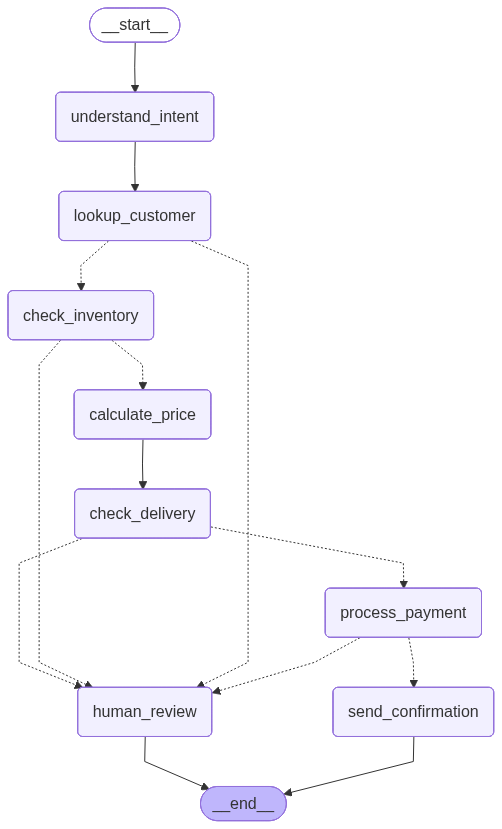

✅ Graph visualization displayed above


In [17]:
try:
    from IPython.display import Image, display
    # Generate graph visualization
    display(Image(app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization displayed above")
except Exception as e:
    print(f"⚠️ Could not display graph: {e}")
    print("\nGraph structure (text):")
    print(app.get_graph())

## 🎯 Exercises

### Exercise 5: Add a Recommendation Node

**Task**: Enhance the workflow with a recommendation system:

1. Add a `recommend_alternatives` node that uses the `get_product_recommendations` tool
2. When product is unavailable, suggest similar items
3. Route to human review only if customer rejects alternatives

In [18]:
@tool
def get_product_recommendations(occasion: str, preferences: str = "") -> str:
    """Get product recommendations based on occasion and preferences.

    Args:
        occasion: Type of event (e.g., 'birthday', 'wedding', 'anniversary')
        preferences: Customer preferences (e.g., 'chocolate lover', 'vegan')

    Returns:
        Product recommendations
    """
    recommendations = []
    occasion_lower = occasion.lower()
    preferences_lower = preferences.lower()

    for _, product in cakes_df.iterrows():
        score = 0

        if 'birthday' in occasion_lower:
            if 'chocolate' in product['Category'].lower():
                score += 2
        elif 'wedding' in occasion_lower or 'anniversary' in occasion_lower:
            if 'vanilla' in product['Category'].lower() or 'specialty' in product['Category'].lower():
                score += 2

        if 'chocolate' in preferences_lower and 'chocolate' in product['Category'].lower():
            score += 3

        if score > 0:
            recommendations.append((product['Name'], score))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    if recommendations:
        top_3 = recommendations[:3]
        result = f"Top recommendations for {occasion}:\n"
        for name, _ in top_3:
            result += f"  - {name}\n"
        return result
    else:
        return "We recommend our best-selling Chocolate Truffle Cake or Vanilla Bean Cake!"

def recommend_alternatives_node(state: BakeryOrderState) -> BakeryOrderState:
    """Recommend alternative products when requested item unavailable"""
    print("💡 NODE: Recommending Alternatives...")

    # TODO: Implement recommendation logic
    # 1. Use get_product_recommendations tool
    # 2. Update state with alternatives
    # 3. Ask customer if they want an alternative

    # For now, just mark for human review
    state['requires_human_review'] = True
    state['messages'].append(AIMessage(
        content="The requested product is unavailable. Let me suggest some alternatives!"
    ))

    return state

# TODO: Add this node to the workflow
# TODO: Update conditional routing after inventory check

### Exercise 6: Add Agent-Powered Decision Node

**Task**: Create a node that uses the LLM with tools to make complex decisions:

1. Create an `agent_decision` node that has access to all tools
2. Let the LLM decide which tools to call based on the situation
3. Handle complex customer requests that require multiple tool calls

In [19]:
# TODO: Create agent node that can call multiple tools
# Hint: Use create_react_agent or create_openai_functions_agent

## Summary: What We Built

### ✅ Session 2.3 Achievements:

1. **LangGraph Basics**: Nodes, edges, and state
2. **Tool Integration**: Used actual tools from Notebooks 1 & 2
3. **Agent-Powered Nodes**: LLM-based decision making
4. **Stateful Workflow**: Complete order processing pipeline
5. **Conditional Routing**: Dynamic flow based on conditions
6. **Error Handling**: Human review for edge cases
7. **Streaming**: Real-time workflow execution
8. **Visualization**: Graph structure display

### 🎨 BakeryAI Workflow Features:

✨ **Intent Understanding**: LLM-powered intent detection
✨ **Customer Lookup**: Database integration
✨ **Inventory Checks**: Real-time availability
✨ **Price Calculation**: Dynamic pricing
✨ **Delivery Verification**: Slot availability
✨ **Payment Processing**: Secure transactions
✨ **Email Notifications**: Automated confirmations
✨ **Smart Routing**: Conditional flow control
✨ **Human Oversight**: Escalation when needed

### 🚀 Next: Notebook 2.4

We'll build **multi-agent systems** with:
- Multiple specialized agents (customer service, inventory, kitchen)
- Agent coordination and communication
- Supervisor patterns
- Complex real-world scenarios